Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [2]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime
import pathlib

import sys
before = {str(m) for m in sys.modules}
# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas as pd


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels.multivariate.pca
import statsmodels.tsa.seasonal


# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

# this package gives a lot of warnings about incompatibility with 3.1 
# replace 
import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

# add the top level package
import slr.models
import slr.psmsl

In [15]:
# Some coordinate systems
WEBMERCATOR = pyproj.Proj('epsg:3857')
WGS84 = pyproj.Proj('epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook

# use local data, make sure you updated the datasets with the makefiles
local = True

# directory to the sealevel 
src_dir = pathlib.Path('~/Projects/SmallProjects/ZeespiegelMonitor/zsm_code/').expanduser()


Loading BokehJS ...

In [16]:
src_dir

PosixPath('/Users/dewilebars/Projects/SmallProjects/ZeespiegelMonitor/zsm_code')

Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

In [17]:
psmsl_urls_remote = {
    'met_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
    'rlr_monthly': 'http://www.psmsl.org/data/obtaining/rlr.monthly.data/rlr_monthly.zip',
    'rlr_annual': 'http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip'
}
psmsl_data_dir = src_dir / 'data' / 'psmsl'
psmsl_urls_local = {
    'met_monthly': psmsl_data_dir / 'met_monthly.zip',
    'rlr_monthly': psmsl_data_dir / 'rlr_monthly.zip',
    'rlr_annual': psmsl_data_dir / 'rlr_annual.zip'
}
if local:
    psmsl_urls = psmsl_urls_local
else:
    psmsl_urls = psmsl_urls_remote
default_dataset_name = 'rlr_annual'

In [18]:
# the rlrnap computes the rlr back to  latest NAP (ignoring the undoing of the NAP correction)
# the alpha paramater is the dominant wind direction for the stations, based on de Ronde 2013
# id's are the station ids in the PSMSL dataset

# Make sure that you verify the rlr2nap parameters. They may change from year to year  as the PSMSL 0 point is arbitary.
# You can lookup the relevant parameters in the schematic diagram like this:
# https://www.psmsl.org/data/obtaining/rlr.diagrams/20.php

main_stations_path = src_dir / 'data' / 'deltares' / 'main_stations.json'
main_stations = pd.read_json(main_stations_path)
main_stations = main_stations.set_index('id')
main_stations

,name,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,station_high,summary,img,nulpaal,links
id,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,9.00,This station is located at a quay in Vlissinge...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4068'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,9.05,The station in Hoek van Holland is located bes...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4021', 'length': 28.35, 'foot': -2...",[{'href': 'http://geodesy.unr.edu/NGLStationPa...
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,8.47,This station is located in the dike of Den Hel...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4036', 'length': 17.5, 'foot': -12...",[]
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,10.18,The tidal measurement station in Delfzijl is l...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4041'},[{'href': 'http://geodesy.unr.edu/NGLStationPa...
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,8.54,The tidal station in Harlingen is located in a...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4020', 'length': 28, 'foot': -22, ...",[]
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,10.35,IJmuiden is located on the northern part of th...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4049'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...


In [19]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.index)
main_stations_idx

[20, 22, 23, 24, 25, 32]

In [21]:
# download the zipfile

zipfiles = {}


for dataset_name in psmsl_urls:
    if local:
        zf = zipfile.ZipFile(psmsl_urls_local[dataset_name])
    else:
        resp = requests.get(psmsl_urls_remote[dataset_name])
        # we can read the zipfile
        stream = io.BytesIO(resp.content)
        zf = zipfile.ZipFile(stream)
    zipfiles[dataset_name] = zf

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zipfiles[dataset_name].read('{}/filelist.txt'.format(dataset_name))

stations = pd.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = pd.merge(main_stations, stations, left_index=True, right_index=True)
# set the main stations, this should be a list of 6 stations
selected_stations['name'] = selected_stations['name_x']
selected_stations

,name_x,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,...,img,nulpaal,links,lat,lon,name_y,coastline_code,station_code,quality,name
id,,,,,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4068'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...,51.442222,3.596111,VLISSINGEN,150,101,N,Vlissingen
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4021', 'length': 28.35, 'foot': -2...",[{'href': 'http://geodesy.unr.edu/NGLStationPa...,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,Hoek van Holland
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4036', 'length': 17.5, 'foot': -12...",[],52.964444,4.745000,DEN HELDER,150,31,N,Den Helder
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4041'},[{'href': 'http://geodesy.unr.edu/NGLStationPa...,53.326389,6.933056,DELFZIJL,150,1,N,Delfzijl
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,...,http://www.openearth.nl/sealevel/static/images...,"{'id': '000A4020', 'length': 28, 'foot': -22, ...",[],53.175556,5.409444,HARLINGEN,150,21,N,Harlingen
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,...,http://www.openearth.nl/sealevel/static/images...,{'id': '000A4049'},[{'href': 'http://gnss1.tudelft.nl/dpga/statio...,52.462222,4.554722,IJMUIDEN,150,41,N,IJmuiden


In [22]:
# show all the stations on a map

# compute the bounds of the plot
sw = (50, -5)
ne = (55, 10)
# transform to web mercator
wgs2web = pyproj.Transformer.from_proj(WGS84, WEBMERCATOR, always_xy=True)
sw_wm = wgs2web.transform(sw[1], sw[0])
ne_wm = wgs2web.transform(ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=200, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles

fig.add_tile(bokeh.tile_providers.get_provider('STAMEN_TERRAIN'))
# add the stations
x, y = wgs2web.transform(np.array(stations.lon), np.array(stations.lat))
fig.circle(x, y)
x, y = wgs2web.transform(np.array(selected_stations.lon), np.array(selected_stations.lat))
_ = fig.circle(x, y, color='red')


In [23]:
# show the plot
bokeh.io.show(fig)

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

In [24]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
url_names = {
    'datum': '{dataset_name}/RLR_info/{id}.txt',
    'diagram': '{dataset_name}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'rlr_monthly': '{dataset_name}/data/{id}.rlrdata',
    'rlr_annual': '{dataset_name}/data/{id}.rlrdata',
    'met_monthly': '{dataset_name}/data/{id}.metdata',
    'doc': '{dataset_name}/docu/{id}.txt',
    'contact': '{dataset_name}/docu/{id}_auth.txt'
}

In [25]:
def get_url(station, dataset_name):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset_name=dataset_name,
        id=station.name
    )
    url = url_names['url'].format(**info)
    return url

for dataset_name in psmsl_urls:
    # fill in the dataset parameter using the global dataset_name
    f = functools.partial(get_url, dataset_name=dataset_name)
    # compute the url for each station
    selected_stations[dataset_name] = selected_stations.apply(f, axis=1)
selected_stations

,name_x,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,foundation_low,station_low,...,lat,lon,name_y,coastline_code,station_code,quality,name,met_monthly,rlr_monthly,rlr_annual
id,,,,,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,-17.6,2.50,...,51.442222,3.596111,VLISSINGEN,150,101,N,Vlissingen,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,-3.3,5.27,...,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,Hoek van Holland,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,-5.0,5.00,...,52.964444,4.745000,DEN HELDER,150,31,N,Den Helder,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,-20.0,1.85,...,53.326389,6.933056,DELFZIJL,150,1,N,Delfzijl,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,-5.4,5.55,...,53.175556,5.409444,HARLINGEN,150,21,N,Harlingen,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,-13.0,4.20,...,52.462222,4.554722,IJMUIDEN,150,41,N,IJmuiden,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...


Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanalysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of climate change related explanatory variables like trends in density and ice loss at Greenland and Antarctica. These are calculated seperately (see analysis notebooks). Here we only include the incidental (storms) and periodic (tide). We also show the irregular periodic North Atlantic Osciliation here, but we don't correct for it, as this metric does not have such a strong correlation with the water level at the Dutch coast, thus including it will also reduce the explainability of the current sea-level rise. 

In [26]:
def make_wind_df(lat_i=53, lon_i=3):
    """create a dataset for wind, for 1 latitude/longitude"""
    # the following url's are not available during a government shutdown
    u_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/uwnd.10m.mon.mean.nc'
    v_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/vwnd.10m.mon.mean.nc'
    
    if local:
        u_file = pathlib.Path(src_dir / 'data/noaa/uwnd.10m.mon.mean.nc').expanduser()
        v_file = pathlib.Path(src_dir / 'data/noaa/vwnd.10m.mon.mean.nc').expanduser()

    # open the 2 files
    ds_u = netCDF4.Dataset(u_file)
    ds_v = netCDF4.Dataset(v_file)
    
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_u.variables['lat'][:], ds_u.variables['lon'][:], ds_u.variables['time'][:]
    
    # check with the others
    lat_v, lon_v, time_v = ds_v.variables['lat'][:], ds_v.variables['lon'][:], ds_v.variables['time'][:]
    assert (lat == lat_v).all() and (lon == lon_v).all() and (time == time_v).all()
    
    # convert to datetime
    # Now defaults to return cftime dates https://github.com/Unidata/cftime/issues/136
    # cftime dates are not recognized by pandas
    # in cftime < 1.2.1 there is a bug that this flag doesn't not function properly
    t = netCDF4.num2date(time, ds_u.variables['time'].units, only_use_cftime_datetimes=False)
    
    def find_closest(lat, lon, lat_i=lat_i, lon_i=lon_i):
        """lookup the index of the closest lat/lon"""
        Lon, Lat = np.meshgrid(lon, lat)
        idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
        Lat.ravel()[idx], Lon.ravel()[idx]
        [i, j] = np.unravel_index(idx, Lat.shape)
        return i, j
    
    # this is the index where we want our data
    i, j = find_closest(lat, lon)
    
    # get the u, v variables
    print('found point', lat[i], lon[j])
    u = ds_u.variables['uwnd'][:, i, j]
    v = ds_v.variables['vwnd'][:, i, j]

    # compute derived quantities
    speed = np.sqrt(u**2 + v**2)
    
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    
    # put everything in a dataframe
    wind_df = pd.DataFrame(data=dict(u=u, v=v, t=t, speed=speed, direction=direction))
    wind_df = wind_df.set_index('t')


    # return it
    return wind_df
wind_df = make_wind_df()

found point 52.3799 3.75


In [100]:
# label set to xxxx-01-01 of the current year
annual_wind_df = wind_df.groupby(pd.Grouper(freq='1Y', label='left')).mean()
annual_wind_df.index = annual_wind_df.index + datetime.timedelta(days = 1)
#annual_wind_df = wind_df.resample('A', label='left', loffset=datetime.timedelta(days=1)).mean()
annual_wind_df['speed'] = np.sqrt(annual_wind_df['u']**2 + annual_wind_df['v']**2)
annual_wind_df['direction'] = np.mod(np.angle(annual_wind_df['u'] + annual_wind_df['v'] * 1j), 2*np.pi)

In [101]:
annual_wind_df

,u,v,speed,direction
t,,,,
1948-01-01,1.690830,1.660677,2.369970,0.776402
1949-01-01,2.302918,0.567158,2.371729,0.241472
1950-01-01,1.953580,1.130130,2.256916,0.524455
1951-01-01,1.234915,1.334031,1.817871,0.823962
1952-01-01,1.854725,-0.196918,1.865149,6.177411
...,...,...,...,...
2018-01-01,1.040327,0.753799,1.284715,0.627032
2019-01-01,2.176913,1.344536,2.558657,0.553285
2020-01-01,2.207300,1.752432,2.818367,0.671026


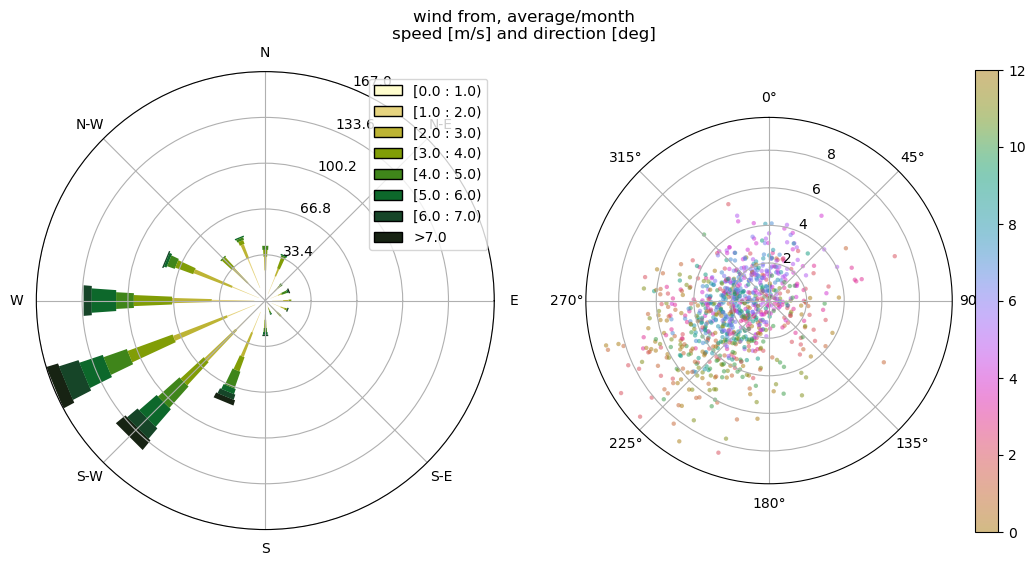

In [102]:
# create a wide figure, showing 2 wind roses with some extra info
fig = plt.figure(figsize=(13, 6))
# we're creating 2 windroses, one boxplot
ax = fig.add_subplot(1, 2, 1, projection='windrose')
ax = windrose.WindroseAxes.from_ax(ax=ax)
# from radians 0 east, ccw to 0 north cw, use meteo convention of "wind from" (270 - math degrees)
# see for example: http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html
wind_direction_meteo = np.mod(270 - (360.0 * wind_df.direction / (2*np.pi)), 360)
# create a box plot
ax.box(wind_direction_meteo, wind_df.speed, bins=np.arange(0, 8, 1), cmap=cmocean.cm.speed)
ax.legend(loc='best')

# and a scatter showing the seasonal pattern (colored by month)
ax = fig.add_subplot(1, 2, 2, 
    projection='polar',
    theta_direction=-1,
    theta_offset=np.pi/2.0
)
N = matplotlib.colors.Normalize(1, 12)
months = [x.month for x in wind_df.index]
sc = ax.scatter(
    # here we need radians, but again use math -> meteo conversion
    (np.pi + np.pi/2)-wind_df.direction, 
    wind_df.speed, 
    c=months, 
    cmap=cmocean.cm.phase, 
    vmin=0, 
    vmax=12,
    alpha=0.5,
    s=10,
    edgecolor='none'
)
_ = plt.colorbar(sc, ax=ax)
_ = fig.suptitle('wind from, average/month\nspeed [m/s] and direction [deg]')

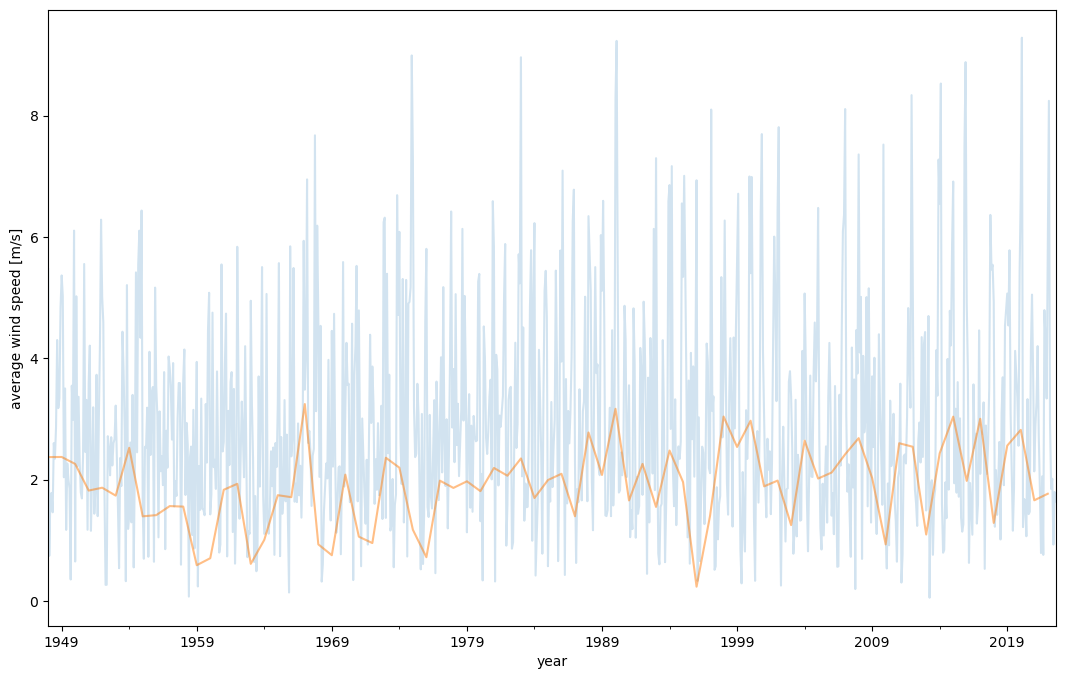

In [103]:
fig, ax = plt.subplots(figsize=(13, 8))
wind_df['speed'].plot(alpha=0.2, ax=ax)
annual_wind_df['speed'].plot(alpha=0.5, ax=ax)
ax.set_xlabel('year')
ax.set_ylabel('average wind speed [m/s]');

In [104]:
# get data for all stations
for dataset_name in psmsl_urls:
    f = functools.partial(
        # this  function  fills in missing wind with nan
        slr.psmsl.get_data_with_wind, 
        dataset_name=dataset_name, 
        wind_df=wind_df, 
        annual_wind_df=annual_wind_df,
        zipfiles=zipfiles,
        url_names=url_names
    )
    # look up the data for each station
    selected_stations[dataset_name] = [f(station) for _, station in selected_stations.iterrows()]

Now that we have all data downloaded we can compute the mean.

In [105]:
# compute the mean

grouped = pd.concat(selected_stations[dataset_name].tolist())[['year', 'height', 'u2', 'v2']].groupby(['year'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890].copy()

In [107]:
def timeseries_plot(dataset_name=default_dataset_name):
    # show all the stations, including the mean
    title = 'Sea-surface height for Dutch tide gauges [{year_min} - {year_max}]'.format(
        year_min=mean_df.year.min(),
        year_max=mean_df.year.max() 
    )
    fig = bokeh.plotting.figure(title=title, x_range=(1860, 2020), plot_width=900, plot_height=400)
    colors = list(bokeh.palettes.Accent7)
    # no yellow
    del colors[3]
    for color, (id_, station) in zip(colors, selected_stations.iterrows()):
        data = station[dataset_name]
        fig.circle(data.year, data.height, color=color, legend_label=station['name'], alpha=0.5, line_width=1)
    fig.line(mean_df.year, mean_df.height, line_width=1, alpha=0.7, color='black', legend_label='Mean')
    fig.legend.location = "bottom_right"
    fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig


In [108]:
bokeh.io.show(timeseries_plot(default_dataset_name))

In [109]:
bokeh.io.show(timeseries_plot('rlr_monthly'))

In [110]:
# show table with highest 5 years (mean of stations)
mean_5yMax = (
    mean_df[["year", "height"]]
    .set_index(["year"])
    .sort_values("height", ascending=False)["height"]
    .nlargest(5)
)
table_mean = (
    mean_5yMax.to_frame()
    .style.set_caption("Highest 5 years (averaged over stations)")
    .format({"height": "{:.1f}"})
)
IPython.display.display(table_mean)

# show table with highest 5 years per station
data_select = pd.concat(selected_stations[dataset_name].tolist())[
    ["station", "year", "height", "u2", "v2"]
]
data_select["station"] = data_select["station"].map(selected_stations["name_x"])
data_5yMax = (
    data_select.set_index(["year"])
    .sort_values("height", ascending=False)
    .groupby(["station"])["height"]
    .nlargest(5)
)
# table_stat = data_5yMax.to_frame().style.set_caption('Highest 5 years per station').format({'height': "{:.1f}"})
# IPython.display.display(table_stat)

# display table horizontally
df1_styler = (
    data_5yMax[0 : int(len(data_5yMax) / 3)]
    .to_frame()
    .style.set_table_attributes("style='display:inline'")
    .set_caption("Highest 5 years per station")
    .format({"height": "{:.1f}"})
)
df2_styler = (
    data_5yMax[int(len(data_5yMax) / 3) : int(len(data_5yMax) / 3 * 2)]
    .to_frame()
    .style.set_table_attributes("style='display:inline'")
    .set_caption("")
    .format({"height": "{:.1f}"})
)
df3_styler = (
    data_5yMax[int(len(data_5yMax) / 3 * 2) :]
    .to_frame()
    .style.set_table_attributes("style='display:inline'")
    .set_caption("")
    .format({"height": "{:.1f}"})
)
IPython.display.display_html(
    df1_styler._repr_html_() + df2_styler._repr_html_() + df3_styler._repr_html_(),
    raw=True,
)

,height
year,
2020,114.7
2017,112.2
2019,109.2
2007,94.8
2021,93.5


Highest 5 years per station 
 
 
   
   
 height 
 
 
 station 
 year 
   
 
 
 
 
 Delfzijl 
 2020 
 205.0 
 
 
 2017 
 202.0 
 
 
 2019 
 195.0 
 
 
 2021 
 182.0 
 
 
 2015 
 179.0 
 
 
 Den Helder 
 2019 
 71.0 
 
 
 2020 
 70.0 
 
 
 2017 
 56.0 
 
 
 2007 
 42.0 
 
 
 2021 
 42.0 
 
 
 

 
 
 
   
   
 height 
 
 
 station 
 year 
   
 
 
 
 
 Harlingen 
 2020 
 153.0 
 
 
 2017 
 149.0 
 
 
 2015 
 140.0 
 
 
 2019 
 140.0 
 
 
 2007 
 122.0 
 
 
 Hoek van Holland 
 2019 
 138.0 
 
 
 2020 
 136.0 
 
 
 2017 
 133.0 
 
 
 2021 
 128.0 
 
 
 2007 
 121.0 
 
 
 

 
 
 
   
   
 height 
 
 
 station 
 year 
   
 
 
 
 
 IJmuiden 
 2017 
 87.0 
 
 
 2007 
 83.0 
 
 
 2020 
 66.0 
 
 
 2015 
 64.0 
 
 
 2019 
 60.0 
 
 
 Vlissingen 
 2020 
 58.0 
 
 
 2019 
 51.0 
 
 
 2021 
 46.0 
 
 
 2007 
 46.0 
 
 
 2017 
 46.0

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that t is relative to the epoch of 1970. This model is referred to as `linear_model` in the code. 
$
H(t) = a + b_{trend}(t) + b_u\cos(2\pi\frac{t}{18.613}) + b_v\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind ($b_{wind^2}$), the autoregressive term $\varepsilon(t-1)$ and error $\varepsilon$. 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise".  This model is refered to as `broken_linear_model`. These models are covered in the section [Sea-level acceleration](#Is-there-a-sea-level-acceleration?).

$
H(t) = a + b_{trend}(t) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. This model is referred to as `quadratic_model`. 

$
H(t) = a + b_{trend}(t) + b_{quadratic}(t*t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t) 
$



We can compare the model with and without wind. Wind drives the storm surge at the coast. If there is a strong wind blowing it can raise the waterlevel by meters, 2 meter is not uncommon. If the wind keeps blowing for two days this will raise the annual averaged waterlevel by more than a centimeter, even if it occurs during low tide. 
We can verify that wind is an important factor for the average sea level by comparing the model with and without wind. 
Things to check for include: 
- Durbin Watson should be >1 for no worries, >2 for no autocorrelation
- JB should be non-significant for normal residuals
- abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful
- The model with wind should also be significant better, check F value difference with 2 and N-5 degrees of freedom. 

In [119]:
# first the model without wind and AR (autogregressive components)
linear_without_wind_fit, linear_without_wind_names = slr.models.linear_model(mean_df, with_wind=False, with_ar=False)
table = linear_without_wind_fit.summary(
    yname='Sea-surface height', 
    xname=linear_without_wind_names, 
    title='Linear model without (1890-current)'
)
IPython.display.display(table)

# and then the model with wind
linear_with_wind_fit, linear_with_wind_names = slr.models.linear_model(mean_df, with_wind=True, with_ar=False)
table = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=linear_with_wind_names,
    title='Linear model with wind (1948-current)'
)
IPython.display.display(table)

# Wikipedia, based on Akaike(1974): Given a set of candidate models 
# for the data, the preferred model is the one with the minimum AIC value. 
if (linear_without_wind_fit.aic < linear_with_wind_fit.aic):
    print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
    linear_fit = linear_without_wind_fit
    with_wind = False
else:
    print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')
    linear_fit = linear_with_wind_fit
    with_wind = True
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Linear model without (1890-current)                      
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     327.9
Date:                Mon, 26 Sep 2022   Prob (F-statistic):           7.03e-60
Time:                        09:49:21   Log-Likelihood:                -630.63
No. Observations:                 132   AIC:                             1269.
Df Residuals:                     128   BIC:                             1281.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -23.4641      2.764     -8.489      0.000     -28.882     -18.047
Trend          1.9400      0.062     31.208      0.000       1.818       2.062
Nodal U        5.1189      3.654      1.401      0.161      -2.042      12.280
Nodal V      -13.0533      3.414     -3.824      0.000     -19.744      -6.363
==============================================================================
Omnibus:                        3.785   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.151   Jarque-Bera (JB):                3.494
Skew:                          -0.397   Prob(JB):                        0.174
Kurtosis:                       3.058   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     394.2
Date:                Mon, 26 Sep 2022   Prob (F-statistic):           4.06e-75
Time:                        09:49:21   Log-Likelihood:                -600.85
No. Observations:                 132   AIC:                             1214.
Df Residuals:                     126   BIC:                             1231.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -62.1694      4.584    -13.562      0.000     -71.154     -53.185
Trend          1.8858      0.052     35.942      0.000       1.783       1.989
Nodal U        3.4936      2.834      1.233      0.218      -2.061       9.048
Nodal V      -10.8286      2.855     -3.792      0.000     -16.425      -5.232
Wind $u^2$    10.8715      1.054     10.318      0.000       8.806      12.937
Wind $v^2$     2.1792      2.418      0.901      0.367      -2.560       6.918
==============================================================================
Omnibus:                        2.457   Durbin-Watson:                   1.599
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.060
Skew:                          -0.160   Prob(JB):                        0.357
Kurtosis:                       3.522   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.


In [120]:
# plot the model with wind. 
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=1, legend_label='Monthly mean sea level', color='black', alpha=0.5)
fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend_label='Current sea level, corrected for wind influence'
)
fig.line(
    linear_without_wind_fit.model.exog[:, 1] + 1970, 
    linear_without_wind_fit.predict(), 
    line_width=3, 
    legend_label='Current sea level', 
    color='green',
    alpha=0.5
)
fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
fig.legend.click_policy = "hide"

bokeh.io.show(fig)

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. There are several coastal interventions with known effect to the stations. The construction of the [Afsluitdijk](https://en.wikipedia.org/wiki/Afsluitdijk) (1927-1932), the [Oosterscheldekering](https://en.wikipedia.org/wiki/Oosterscheldekering) (1969-1987), the [Maeslantkering](https://en.wikipedia.org/wiki/Maeslantkering) (1991-1997) all have influence on the mean sea level, mainly due to changes in tidal amplitudes. 

Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. See the analysis folder for an example.

In [121]:
station_fits = {}
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, linear_names = slr.models.linear_model(df, with_wind=with_wind)
    smry = fit.summary(xname=linear_names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'])
    station_fits[name] = fit

    IPython.display.display(smry.tables[1])

Vlissingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-97.8973,5.423,-18.052,0.000,-108.526,-87.268
Trend,2.1431,0.066,32.447,0.000,2.014,2.273
Nodal U,3.9519,3.120,1.267,0.205,-2.163,10.067
Nodal V,-12.8714,3.480,-3.699,0.000,-19.691,-6.051
Wind $u^2$,6.3382,1.301,4.871,0.000,3.788,8.889
Wind $v^2$,-0.8019,2.930,-0.274,0.784,-6.545,4.941


Hoek van Holland


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-45.2891,6.314,-7.173,0.000,-57.665,-32.913
Trend,2.3186,0.057,40.985,0.000,2.208,2.429
Nodal U,-0.8427,3.237,-0.260,0.795,-7.188,5.502
Nodal V,-8.2719,3.139,-2.636,0.008,-14.423,-2.121
Wind $u^2$,10.6579,1.539,6.926,0.000,7.642,13.674
Wind $v^2$,2.0205,2.650,0.762,0.446,-3.173,7.214


Den Helder


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-100.4452,4.650,-21.603,0.000,-109.558,-91.332
Trend,1.4761,0.057,25.773,0.000,1.364,1.588
Nodal U,3.8207,2.870,1.331,0.183,-1.804,9.445
Nodal V,-12.4290,3.637,-3.417,0.001,-19.558,-5.300
Wind $u^2$,11.8256,1.060,11.152,0.000,9.747,13.904
Wind $v^2$,2.7567,2.767,0.996,0.319,-2.667,8.181


Delfzijl


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-17.2538,5.555,-3.106,0.002,-28.142,-6.365
Trend,1.9601,0.077,25.339,0.000,1.809,2.112
Nodal U,2.3875,4.225,0.565,0.572,-5.894,10.669
Nodal V,-12.2503,3.688,-3.321,0.001,-19.479,-5.021
Wind $u^2$,13.5078,1.334,10.124,0.000,10.893,16.123
Wind $v^2$,2.5185,3.485,0.723,0.470,-4.311,9.348


Harlingen


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-37.0570,6.146,-6.030,0.000,-49.102,-25.012
Trend,1.2947,0.066,19.551,0.000,1.165,1.425
Nodal U,0.6610,3.552,0.186,0.852,-6.301,7.623
Nodal V,-8.9583,3.467,-2.584,0.010,-15.754,-2.162
Wind $u^2$,14.2624,1.405,10.152,0.000,11.509,17.016
Wind $v^2$,5.4655,3.188,1.714,0.086,-0.784,11.715


IJmuiden


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-75.0180,5.609,-13.374,0.000,-86.012,-64.024
Trend,2.0583,0.072,28.534,0.000,1.917,2.200
Nodal U,9.8147,3.939,2.492,0.013,2.095,17.534
Nodal V,-12.6537,3.656,-3.461,0.001,-19.819,-5.488
Wind $u^2$,8.7056,1.282,6.789,0.000,6.192,11.219
Wind $v^2$,1.2932,3.222,0.401,0.688,-5.021,7.607


In [122]:
p = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Accent6

for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, linear_names = slr.models.linear_model(df, with_wind=with_wind)
    p.circle(station[default_dataset_name].year, station[default_dataset_name].height, alpha=0.1, color=color)

# loop again so we have the lines on top
for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station[default_dataset_name][station[default_dataset_name].year >= 1890]
    fit, linear_names = slr.models.linear_model(df, with_wind=with_wind)
    p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend_label=station['name'],
        color=color
    )
p.legend.click_policy = "hide"


bokeh.io.show(p)


Another thing we can look at is the regional variability of unexplained variance. The largest peaks are found in Delfzijl at the start of the measurements. The measured waterlevel was lower in that year. Delfzijl is more affected by storm surges than most other stations due to it's position in the Eems. Another outlier is the measurement in the 30's in Den Helder, this is likely due to the construction of the Afsluitdijk. The other residuals mostly occur on all stations at the same time. This indicates that it is more likely that our estimate of the wind is not optimal yet. We do see a periodicity in the residuals of about 6 years. This does not match with any of the known climate indices. 
Variance descreasess after 1948 because the reanalysis of wind is included after that. 

In [123]:
# TODO:  move this to analysis
nao = pd.read_json('../data/noaa/nao.json')
nao = nao.drop(labels=['missing', 'title'])
nao = nao.reset_index()
nao['date'] = nao['index'].apply(lambda x:  datetime.datetime(year=int(x[:4]), month=int(x[4:6]), day=1))
nao = nao.set_index('date')
nao = nao.rolling(24).mean()

fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True, gridspec_kw=dict(height_ratios=[4,1]))
for i, station_df in selected_stations.iterrows():
    station_df_selected = station_df['rlr_annual'][station_df['rlr_annual']['year'] >= 1890]
    fit, names = slr.models.linear_model(station_df_selected)
    axes[0].plot(station_df_selected.index, fit.resid, label=station_df['name'])
axes[0].grid(True)
_ = axes[0].legend(loc='best')
axes[1].plot(nao.index, nao['data'])

axes[0].set_ylabel('Sea surface height residual [mm]')
axes[1].set_ylabel('NAO index\n24 year moving average')


FileNotFoundError: File ../data/noaa/nao.json does not exist

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [124]:
# use wind if it was a better model
broken_linear_fit, broken_names = slr.models.broken_linear_model(mean_df, with_wind=with_wind)

In [125]:
quadratic_fit, quadratic_names = slr.models.quadratic_model(mean_df, with_wind=with_wind)

In [126]:
# summary of the broken linear model
print('autoregressive parameter rho = %s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname='Sea-surface height', xname=broken_names))


autoregressive parameter rho = [0.1833129]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.887
Model:                          GLSAR   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     251.8
Date:                Mon, 26 Sep 2022   Prob (F-statistic):           6.24e-67
Time:                        09:49:32   Log-Likelihood:                -592.31
No. Observations:                 131   AIC:                             1199.
Df Residuals:                     124   BIC:                             1219.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -63.8876      5.221    -12.237      0.000     -74.120     -53.655
Trend             1.7940      0.085     21.109      0.000       1.627       1.961
+trend (1993)     0.7074      0.323      2.189      0.029       0.074       1.341
Nodal U           3.6163      3.364      1.075      0.282      -2.976      10.209
Nodal V         -11.3081      3.326     -3.400      0.001     -17.827      -4.789
Wind $u^2$       10.9124      1.045     10.438      0.000       8.863      12.961
Wind $v^2$       -0.0996      2.254     -0.044      0.965      -4.517       4.317
==============================================================================
Omnibus:                        2.778   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.614
Skew:                          -0.117   Prob(JB):                        0.271
Kurtosis:                       3.651   Cond. No.                         90.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [127]:
# summary of the quadratic model
print('autoregressive parameter rho = %s' % quadratic_fit.history['rho'][-1])

quadratic_fit.summary(yname='Sea-surface height', xname=quadratic_names)

autoregressive parameter rho = [0.19770699]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.882
Model:                          GLSAR   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     226.0
Date:                Mon, 26 Sep 2022   Prob (F-statistic):           2.91e-64
Time:                        09:49:36   Log-Likelihood:                -593.37
No. Observations:                 131   AIC:                             1201.
Df Residuals:                     124   BIC:                             1221.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Constant       -61.9353      5.353    -11.571      0.000     -72.426     -51.445
Trend            1.8948      0.073     25.946      0.000       1.752       2.038
Acceleration     0.0006      0.002      0.351      0.726      -0.003       0.004
Nodal U          3.2842      3.432      0.957      0.339      -3.442      10.010
Nodal V        -11.4815      3.395     -3.382      0.001     -18.136      -4.827
Wind $u^2$      10.8572      1.061     10.237      0.000       8.779      12.936
Wind $v^2$       1.0721      2.384      0.450      0.653      -3.600       5.745
==============================================================================
Omnibus:                        2.843   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.695
Skew:                          -0.122   Prob(JB):                        0.260
Kurtosis:                       3.659   Cond. No.                     5.09e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 5.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Constant wind trend
Here we compute the linear model with constant wind and tide

In [128]:
# before reanalysis started wind  is filled  in with mean,  let's use it from there
mean_wind = mean_df.set_index('year').loc[1890][['u2', 'v2']]
const = linear_with_wind_fit.params['const'] 
trend = linear_with_wind_fit.params['x1'] 
u2 = linear_with_wind_fit.params['x4'] 
v2 = linear_with_wind_fit.params['x5'] 

# linear_with_wind_fit.predict(mean_df)
linear_with_wind_fit.model.exog.shape, linear_with_wind_fit.model.exog_names
exog_df = pd.DataFrame(
    linear_with_wind_fit.model.exog, 
    columns=linear_with_wind_fit.model.exog_names
).copy()
msg = 'Check variable numbers in code below, they changed'
assert linear_with_wind_names == ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Wind $u^2$', 'Wind $v^2$'], msg
# take 0 nodal tide
exog_df['x2'] = 0 # 
exog_df['x3'] = 0 # 
# take the average wind
exog_df['x4'] = mean_wind['u2']
exog_df['x5'] = mean_wind['v2']
linear_with_mean_wind = linear_with_wind_fit.predict(exog_df)
linear_with_mean_wind_prediction = linear_with_wind_fit.get_prediction(exog=exog_df)
linear_with_mean_wind_confidence_interval = linear_with_mean_wind_prediction.conf_int(obs=False)
linear_with_mean_wind_prediction_interval = linear_with_mean_wind_prediction.conf_int(obs=True)
linear_with_wind_confidence_interval = linear_with_wind_fit.get_prediction().conf_int(obs=False)
linear_with_wind_prediction_interval = linear_with_wind_fit.get_prediction().conf_int(obs=True)



In [129]:
# Extract parameters  and input parameters of the linear model for tide

# Nodal parameters should be stored as x2, x3 in the fit
assert linear_with_wind_names[linear_with_wind_fit.model.exog_names.index('x2')] == 'Nodal U'
assert linear_with_wind_names[linear_with_wind_fit.model.exog_names.index('x3')] == 'Nodal V'


exog_u = linear_with_wind_fit.model.exog[:, linear_with_wind_fit.model.exog_names.index('x2')]
param_u = linear_with_wind_fit.params['x2']
exog_v = linear_with_wind_fit.model.exog[:, linear_with_wind_fit.model.exog_names.index('x3')]
param_v = linear_with_wind_fit.params['x3']

sea_surface_height_due_to_tide = exog_u * param_u + exog_v * param_v

Text(0, 0.5, 'sea surface height due to tide [mm]')

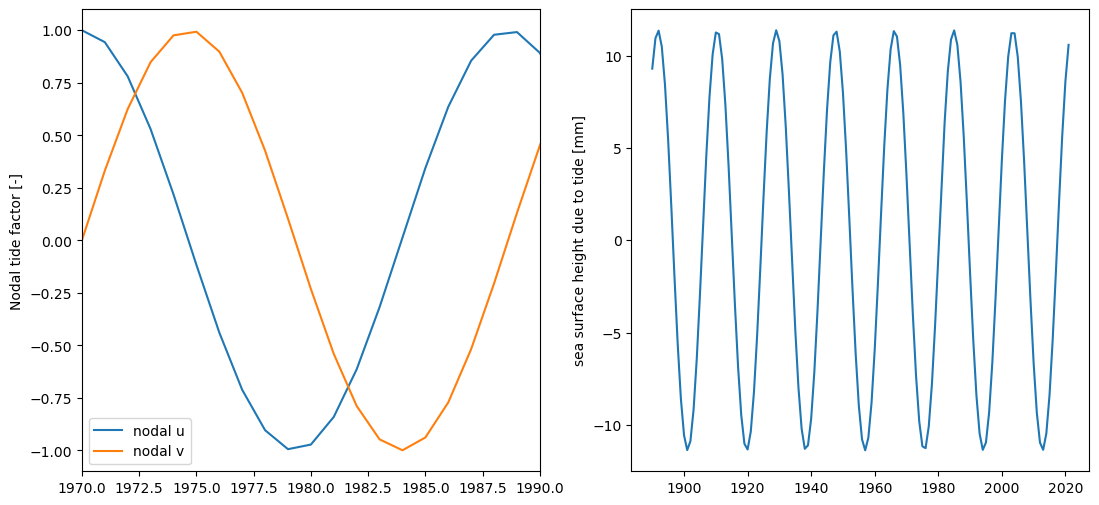

In [130]:
# This should show a cos (u) and sine (v) function with 1 period
fig, axes = plt.subplots(ncols=2, figsize=(13, 6))
ax = axes[0]
ax.plot(mean_df['year'], exog_u, label='nodal u')
ax.plot(mean_df['year'], exog_v, label='nodal v')
ax.legend()
ax.set_ylabel('Nodal tide factor [-]')
ax.set_xlim(1970, 1990)
ax = axes[1]
ax.plot(mean_df['year'], sea_surface_height_due_to_tide, label='sea surface height due to tide [mm]')
ax.set_ylabel('sea surface height due to tide [mm]')

In [131]:
def model_compare_plot():
    colors = bokeh.palettes.Category10[10]
    
    fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
    
    fig.circle(mean_df.year, mean_df.height, line_width=3, legend_label='Observed', color='black', alpha=0.5)
    
    # obser
    fig.line(mean_df.year, linear_with_wind_fit.predict(), line_width=3, legend_label='Linear (with wind)', color=colors[0])
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_wind_confidence_interval[::-1, 0], linear_with_wind_confidence_interval[:, 1]],
        color=colors[0],
        alpha=0.3,
        legend_label='Linear (with wind)'
    )
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_wind_prediction_interval[::-1, 0], linear_with_wind_prediction_interval[:, 1]],
        color=colors[0],
        alpha=0.1,
        legend_label='Linear (with wind)'
    )

    fig.line(mean_df.year, linear_with_mean_wind, line_width=3, color=colors[2], legend_label='Linear (mean wind, 0 tide)')
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_mean_wind_confidence_interval[::-1, 0], linear_with_mean_wind_confidence_interval[:, 1]],
        color=colors[2],
        alpha=0.3, 
        legend_label='Linear (mean wind, 0 tide)'
    )
    fig.patch(
        np.r_[mean_df.year[::-1], mean_df.year],
        np.r_[linear_with_mean_wind_prediction_interval[::-1, 0], linear_with_mean_wind_prediction_interval[:, 1]],
        color=colors[2],
        alpha=0.1, 
        legend_label='Linear (mean wind, 0 tide)'
    )
    
    # alternative models
    
    fig.line(mean_df.year, linear_without_wind_fit.predict(), line_width=3, legend_label='Linear (no wind)', color=colors[1])    
    fig.line(mean_df.year, broken_linear_fit.predict(), line_width=3, color=colors[3], legend_label='Broken (with wind)')
    fig.line(mean_df.year, quadratic_fit.predict(), line_width=3, color=colors[4], legend_label='Quadratic (with wind)')
    
    fig.line(mean_df.year, mean_df.height.rolling(18, center=True).mean(), line_width=3, color=colors[5], legend_label='Rolling 18 year mean (centered)')
    fig.line(mean_df.year, mean_df.height.rolling(7, center=True).mean(), line_width=3, color=colors[6], legend_label='Rolling 7 year mean (centered)')
    
    fig.legend.location = "top_left"
    fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
    fig.xaxis.axis_label = 'year'
    fig.legend.click_policy = "hide"
    return fig
bokeh.io.show(model_compare_plot())

# Export
Here we export the data in csv format. This information is often requested by others.


In [34]:
export_df = mean_df.copy().reset_index()
export_df['predicted_linear_with_wind'] = linear_with_wind_fit.predict()
export_df['predicted_linear_without_wind'] = linear_without_wind_fit.predict()
export_df['predicted_linear_mean_wind'] = linear_with_mean_wind
export_df['predicted_linear_mean_wind_ci_025'] = linear_with_mean_wind_confidence_interval[:, 0]
export_df['predicted_linear_mean_wind_ci_975'] = linear_with_mean_wind_confidence_interval[:, 1]
export_df['predicted_linear_mean_wind_pi_025'] = linear_with_mean_wind_prediction_interval[:, 0]
export_df['predicted_linear_mean_wind_pi_975'] = linear_with_mean_wind_prediction_interval[:, 1]
export_df['sea_surface_height_due_to_tide']  = sea_surface_height_due_to_tide
export_df['date'] = export_df['year'].apply(lambda year: datetime.date(year=year, month=1, day=1))
header = """\
# Sea surface height for the Netherlands based on the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
# predicted_linear_without_wind -> fitted sea surface height based on linear model with tide [mm relative to NAP(2005)]
# predicted_linear_mean_wind  -> fitted sea surface height based on linear model with wind and mean nodal tide   [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% prediction interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% prediction interval [mm relative to NAP(2005)]
# sea_surface_height_due_to_tide  -> fitted nodal tide based on linear model with wind [mm relative to NAP(2005)]
"""
stream = io.StringIO()
stream.write(header)
export_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

29237

In [35]:
header = """\
# Sea surface height for the Netherlands  for the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
"""
dfs = []
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890].copy()
    fit = station_fits[name]
    predicted_linear_with_wind = fit.predict()   
    df['predicted_linear_with_wind'] = predicted_linear_with_wind
    dfs.append(df.reset_index())
export_stations_df = pd.concat(dfs)
stream = io.StringIO()
stream.write(header)
export_stations_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-stations-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

106131

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [132]:
# this section asserts that we have wind selected (because we use the with_mean_wind fit, which is only available if there is wind)
assert with_wind, "Here we assume the wind model was selected. Adapt this code so it mean_wind works with model without wind"

observed = mean_df.height.iloc[-1] / 10.0 # mm to cm
height_corrected_cm = linear_with_mean_wind.iloc[-1] / 10 # mm to cm
height_uncorrected_cm = linear_with_wind_fit.predict()[-1]/10.0 #mm to cm
current_year = mean_df['year'].iloc[-1] 
rate = linear_fit.params.x1*100.0/10 # mm/yr to cm/century
t_start = mean_df.year.iloc[0]
t_end = mean_df.year.iloc[-1]

msg = f'''
- The observed water level, based on the 6 main tide gauges, in {current_year} was {observed:.1f} cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year {current_year} is {height_uncorrected_cm:.1f} cm above NAP. This is the  sea surface height that we would expect based on tide and wind.
- In a year with average wind and tide we would have expected a sea level of {height_corrected_cm:.1f} cm. 
- The current sea-level rise over the period {t_start} through {t_end} is {rate:.1f} cm/century based on the model {"with" if with_wind else "without"} wind. '''

IPython.display.Markdown(msg)


- The observed water level, based on the 6 main tide gauges, in 2021 was 9.3 cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year 2021 is 7.4 cm above NAP. This is the  sea surface height that we would expect based on tide and wind.
- In a year with average wind and tide we would have expected a sea level of 7.2 cm. 
- The current sea-level rise over the period 1890 through 2021 is 18.9 cm/century based on the model with wind. 

In [133]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

The quadratic model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.


In [134]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')
    
    

The broken linear model is a higher quality model (smaller AIC) than the linear model.
The trend break is bigger than we would have expected under the assumption that there was no trend break.


In [135]:
# Show trends before and after 1993 for comparison with altimetry
broken_params = dict(zip(broken_names, broken_linear_fit.params.values))
trend_since_1993 = broken_params['Trend'] + broken_params['+trend (1993)']
print('The trend since 1993 is {:.2f} mm/year. This period can be used to compare with satellite altimetry.'.format(trend_since_1993))
print('The trend before 1993 was {:.2f} mm/year'.format(broken_params['Trend']))


The trend since 1993 is 2.50 mm/year. This period can be used to compare with satellite altimetry.
The trend before 1993 was 1.79 mm/year
